# Workshop 2: Connectivity principles and structure function analysis

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">


In this workshop, we explore different two principles that govern which neurons are connected with each other:

1. Spatial distance between neurons
2. Correlation of acitivity traces during specific stimuli

In [370]:
mat_version = 1169

import os
import sys

HOME = os.path.expanduser("~")
# data_dir = f"{HOME}/SWDB_2025_Connectomics/data/{mat_version}"

# NOTE: adjust for your system
data_dir = f"{HOME}/SWDB_2025_Connectomics/data/"
utils_dir = f"{HOME}/SWDB_2025_Connectomics/code/utils"

sys.path.append(utils_dir)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<h2> Import packages </h2>

In [374]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import itertools
from typing import Union, Optional
from scipy import stats, spatial
import itertools
import tqdm
from os.path import join as pjoin
import collections

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## Preparation

First, we are loading data files that were introduced in the first workshop such as the synapse and cell tables, and information about proofreading. This workshop does not require the CAVEclient.

In [375]:
# Move this to utils

def filter_synapse_table(
    synapse_table: pd.DataFrame, pre_root_ids=None, post_root_ids=None
):
    """Filter synapse table by pre and post root ids.

    Args:
        synapse_table: synapse table with pre_pt_root_ids and post_pt_root_ids as pd.DataFrame
        pre_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the presynaptic side
        post_root_ids: np.ndarray, list or pd.Series if root_ids to filter on the postsynaptic side

    Returns:
        synapse_table: filtered synapse table
    """

    if pre_root_ids is not None:
        assert isinstance(pre_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        pre_mask = np.isin(synapse_table["pre_pt_root_id"], pre_root_ids)
    else:
        pre_mask = np.ones(len(synapse_table), dtype=bool)

    if post_root_ids is not None:
        assert isinstance(post_root_ids, (np.ndarray, list, pd.core.series.Series)), (
            f"IDs have to be of type np.ndarray, list or pd.Series; got {type(pre_root_ids)}"
        )
        post_mask = np.isin(synapse_table["post_pt_root_id"], post_root_ids)
    else:
        post_mask = np.ones(len(synapse_table), dtype=bool)

    return synapse_table[pre_mask & post_mask]


Loading proofreading, cell and synapse information.

In [376]:
# Loads cells with axon and dendrite proofreading
dendrite_proof_root_ids = np.load(pjoin(data_dir, f'proofread_dendrite_list_{mat_version}.npy'))
axon_proof_root_ids = np.load(pjoin(data_dir, f'proofread_axon_list_{mat_version}.npy'))

print(f'There are {len(dendrite_proof_root_ids)} cells with acceptable dendrites, and {len(axon_proof_root_ids)} cells with axon proofreading')
print(f'The number of cells with usable axons and dendrites is: {len(np.isin(axon_proof_root_ids, dendrite_proof_root_ids))}')

There are 63936 cells with acceptable dendrites, and 1207 cells with axon proofreading
The number of cells with usable axons and dendrites is: 1207


In [377]:
syn_df = pd.read_feather(f"{data_dir}/syn_df_all_to_proofread_to_all_{mat_version}.feather")
cell_df = pd.read_feather(f"{data_dir}/soma_and_cell_type_{mat_version}.feather")

In [379]:
cell_df["cell_type"].value_counts()

cell_type
L6-CT    11260
L4-IT     7955
L3-IT     6361
L6-IT     6044
L5-IT     5090
L2-IT     3073
PTC       2951
L5-ET     2013
DTC       1933
ITC       1090
STC        723
L5-NP      699
Name: count, dtype: int64

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## #1: Connection probability vs distance

Neurons are distributed in space. Lets look at the dataset from above. For now, we select one of the cell types available to us: L3-IT

In [380]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

The dataset was not imaged in a perfectly upright position. We corrected for that and created the `*trform*` columns for each neuron position. We will use these for our analysis. However, to find neurons in neuroglancer, one has to still use the not-transformed positions.

In [381]:
sub_cell_df.head(5)

,id,pt_position_x,pt_position_y,pt_position_z,pt_position_trform_x,pt_position_trform_y,pt_position_trform_z,pt_root_id,volume,cell_type_coarse,cell_type
2,203262,624680,531094,283770,-252082.627894,203770.728235,21544.029756,864691132654552792,338.276613,E,L3-IT
80,206060,638648,534819,413820,-241455.293109,242581.092500,150726.999886,864691132956447079,304.910673,E,L3-IT
100,427264,1162836,530629,283095,286300.489495,200408.580896,20827.725145,864691132726948075,337.056665,E,L3-IT
176,349313,900160,569118,73305,24765.534153,182277.697025,-195233.083033,864691132717799744,402.068640,E,L3-IT
190,351373,944314,572378,210330,66224.682100,222567.876415,-57252.408910,864691132656979312,277.321739,E,L3-IT


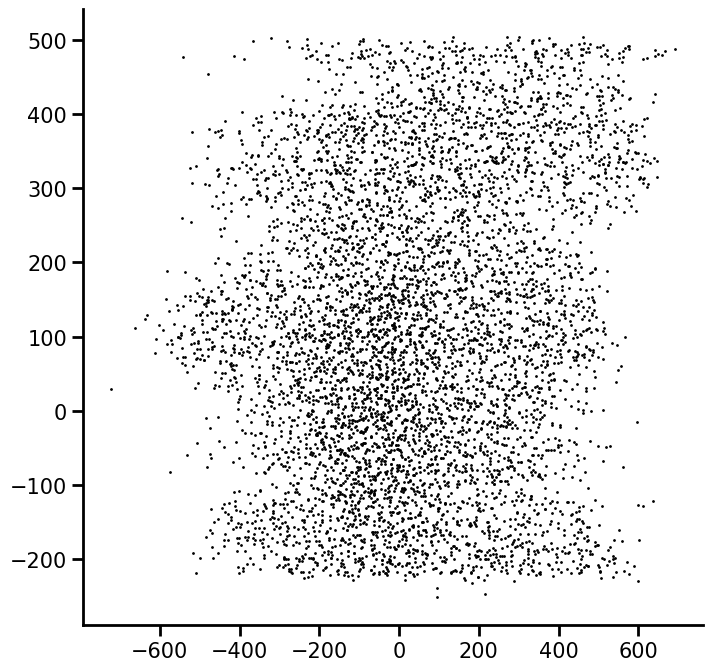

In [382]:
fig, ax = plt.subplots(figsize=(8, 8))

ax.scatter(sub_cell_df["pt_position_trform_x"] / 1000., sub_cell_df["pt_position_trform_z"] / 1000., c="k", s=1)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To test whether distance and connectedness are correlated, we calculate the _lateral_ distance between pairs of neurons. The _lateral_ distance ignores cortical depth. For a pair of neurons the lateral distance can be calculated as the norm of the difference of their coordinates:

In [391]:
pos_cols = ["pt_position_trform_x", "pt_position_trform_z"]

difference = sub_cell_df.iloc[0][pos_cols] - sub_cell_df.iloc[1][pos_cols]
np.linalg.norm(difference)

np.float64(129619.36589966893)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This function computes the lateral distances across all neurons efficiently.

In [394]:
def calculate_lateral_distances(cell_df):
    """ Calculates the lateral distances in µm between all neurons in the dataframe."""
    
    lateral_locations = np.array(cell_df[["pt_position_trform_x", "pt_position_trform_z"]])
    lateral_distances = spatial.distance.cdist(lateral_locations, lateral_locations) / 1000.
    
    id_pairs = list(itertools.product(cell_df["pt_root_id"], cell_df["pt_root_id"]))
    
    lateral_distance_df = pd.DataFrame(id_pairs, columns=['pre_pt_root_id', 'post_pt_root_id'])
    lateral_distance_df['distance'] = lateral_distances.flatten()

    lateral_distance_df = lateral_distance_df[lateral_distance_df['pre_pt_root_id'] != lateral_distance_df['post_pt_root_id']]
    return lateral_distance_df

In [393]:
lateral_distance_df = calculate_lateral_distances(sub_cell_df)
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
1,864691132654552792,864691132956447079,129.619366
2,864691132654552792,864691132726948075,538.383594
3,864691132654552792,864691132717799744,351.620849
4,864691132654552792,864691132656979312,327.915267
5,864691132654552792,864691132681577381,594.564370


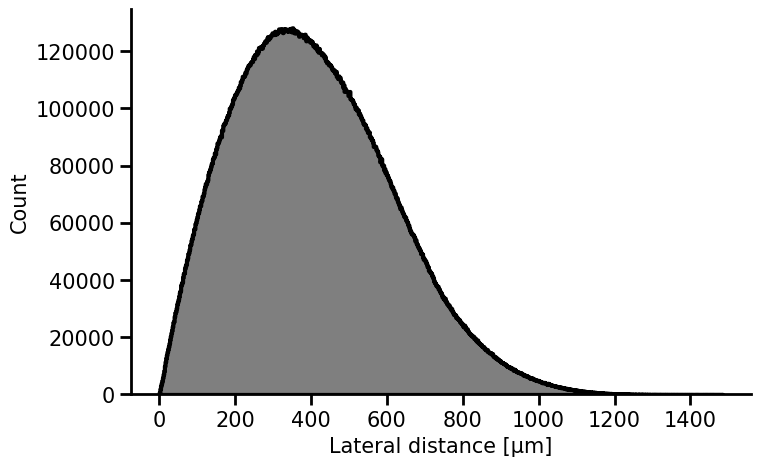

In [395]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", fill=True, alpha=.5, color="k", lw=3, element="step")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  

ax.spines['top'].set_visible(False) 
ax.spines['right'].set_visible(False) 
ax.spines['bottom'].set_linewidth(2)  
ax.spines['left'].set_linewidth(2) 

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Count", fontsize=15)

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

This distribution shows the distance between all pairs of L3-IT neurons in the dataset. Next, we want to compare this distribution with the distances between the all _connected_ neuron pairs to see if they differ. For that, we combine the IDs we selected from our cell table with the proofreading information. Let's gather the proofread L3-IT neurons and use them to filter the synapse table.

In [397]:
pre_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Some neurons are connected with multiple synapses. Here, we will add them together to a single connection.

</div>

In [398]:
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Finally, we need to combine distance and connectivity information. We have this information in two separate dataframes:

In [326]:
conn_df.head(5)

,pre_pt_root_id,post_pt_root_id,size
0,864691132548503618,864691132543938961,2388
1,864691132548503618,864691132569612060,2471
2,864691132548503618,864691132574630714,3758
3,864691132548503618,864691132578853908,4049
4,864691132548503618,864691132579802898,405


In [327]:
lateral_distance_df.head(5)

,pre_pt_root_id,post_pt_root_id,distance
1,864691132654552792,864691132956447079,129.619366
2,864691132654552792,864691132726948075,538.383594
3,864691132654552792,864691132717799744,351.620849
4,864691132654552792,864691132656979312,327.915267
5,864691132654552792,864691132681577381,594.564370


<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> For each connection, we would like to know what the distance is between the two neurons. Write the merge function to combine the distance and synapse information of the two tables. Note that the connectivity table has far fewer entries than the distance table. By merging them, we can filter the distance table down to the neuron pairs for which we have a synaptic connection.

</div>

In [ ]:
conn_dist_df = 

In [400]:
conn_dist_df = pd.merge(conn_df, lateral_distance_df, on=["pre_pt_root_id", "post_pt_root_id"])

In [401]:
conn_dist_df.shape, conn_df.shape, lateral_distance_df.shape

((9579, 4), (9579, 3), (40455960, 3))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's compare the two distribution in plot. We use `stat="probability"` to plot them at the same scale.

</d>

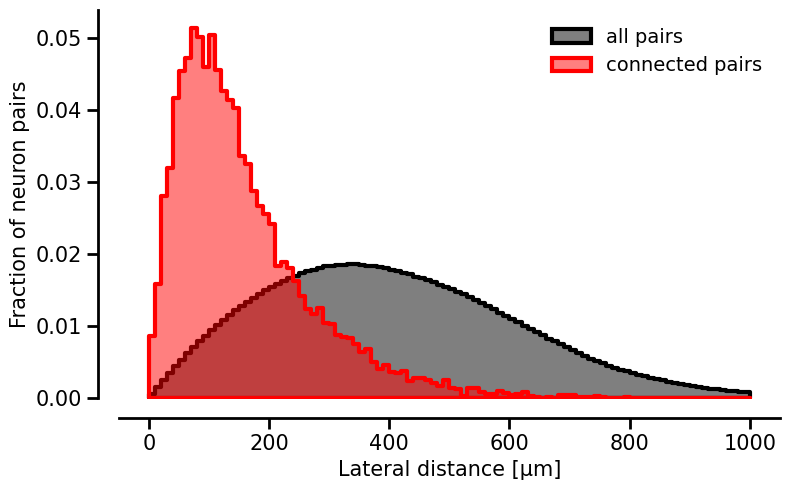

In [402]:
bins = np.linspace(0, 1000, 101)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_df, x="distance", stat="probability", bins=bins, element="step", label="all pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_dist_df, x="distance", stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

To get a better intution, we will look at some examples of connected neuron pairs across distance:

- 10µm: Neuroglancer link
- 50µm: Neuroglancer link
- 100µm: Neuroglancer link
- 500µm: Neuroglancer link

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Question:</b> Is this a fair comparison? Does our NULL distribution, the one of all pairs, represent the set of possible connections well?

</div>

In [321]:
lateral_distance_proofread_df = lateral_distance_df.copy()
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["pre_pt_root_id"], pre_root_ids)]
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["post_pt_root_id"], post_root_ids)]

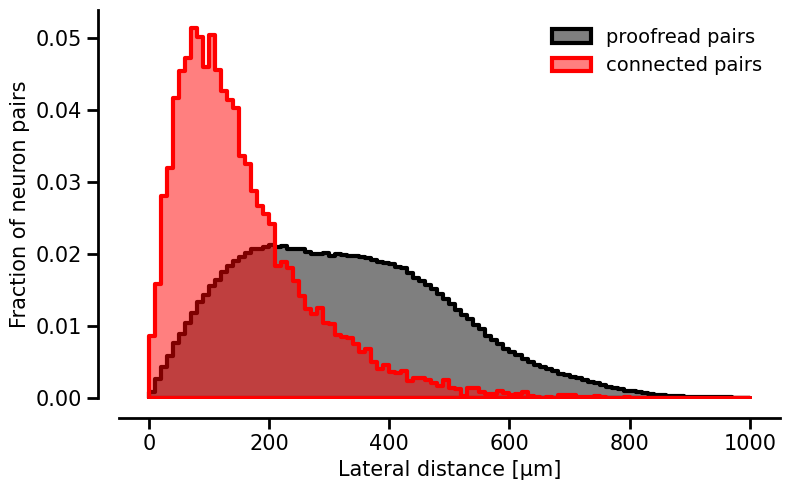

In [322]:
bins = np.linspace(0, 1000, 101)

fig, ax = plt.subplots(figsize=(8, 5))

sns.histplot(lateral_distance_proofread_df, x="distance", stat="probability", bins=bins, element="step", label="proofread pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_dist_df, x="distance", stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Another way to represent the data above is to calculate a "connection probability". That is, <b>how likely is it that two neurons are connected given their lateral distance from each other? </b> 

There are different ways to achieve this, here we will calculate the connection probability for every distance bin.

In [417]:
bins = np.linspace(0, 500, 101)
proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

connection_probability = connected_pair_counts / proofread_pair_counts

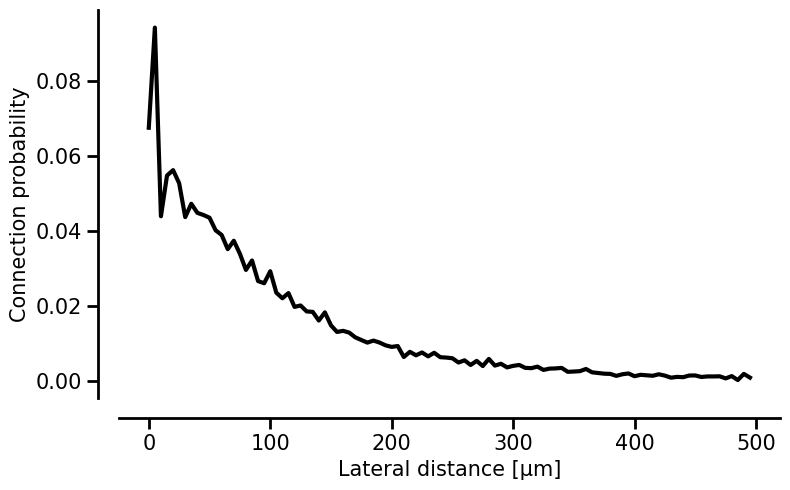

In [418]:
fig, ax = plt.subplots(figsize=(8, 5))

sns.lineplot(x=bins[:-1], y=connection_probability, lw=3, color="k")

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Lateral distance [µm]", fontsize=15)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## #2: Structure vs function: Connectivity vs activity correlation

The V1dd dataset is a structure function dataset. We have functional measurements for many cells in the datasets. These are very rich and can be related to behavioral data. The data is stored in nwb files. Here is an example of the data that is accesible:

In [419]:
# Plot of nwb files

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Activity correlations</b> For the purpose of this workshop, we precalculated correlations between cells. To be more precise, we calculated the total correlation of the activity traces of neurons imaged during the same session during the same stimulus condition.

If you want to use the V1dd dataset for a project, this kind of analysis could be extended to include behavioral data and create more sophisticated functional comparisons between cells which can then be related to the connectivity data.

<b>Coregistration</b>: To analyze the functional and connectivity data, neurons in both datasets need to be _coregistered_, that is an ROI in the activity stack needs to be linked with a cell body in the EM stack. The data below only contains those neurons which were coregistered.

In [425]:
corr_coreg_df = pd.read_feather(f"{data_dir}/cell_cell_correlations_by_stimulus_coregistered.feather")

In [426]:
corr_coreg_df.head(5)

,pre_pt_root_id,post_pt_root_id,drifting_gratings_full,drifting_gratings_windowed,locally_sparse_noise,natural_images,natural_images_12,natural_movie,spontaneous
0,864691132631872354,864691132993747701,0.050142,0.027819,0.154472,0.181724,0.158909,0.004957,0.078471
1,864691132631872354,864691132786447756,0.055267,0.018284,0.119418,0.115587,0.124021,0.010296,0.197349
2,864691132631872354,864691132617961537,0.065444,0.062367,0.143660,0.065078,0.073297,0.053197,0.108968
3,864691132631872354,864691132758875499,0.075457,0.039646,0.057388,0.123202,0.026544,0.025227,0.027960
4,864691132631872354,864691132897987302,0.076981,0.053317,0.107852,0.134347,0.105139,0.022267,0.050300


In [427]:
stimulus_conditions = corr_df.columns[6:]
stimulus_conditions

Index(['drifting_gratings_full', 'drifting_gratings_windowed',
       'locally_sparse_noise', 'natural_images', 'natural_images_12',
       'natural_movie', 'spontaneous'],
      dtype='object')

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Can we treat the different stimulus conditions as separate experiments or would we expect all results to be similar no matter what stimulus condition we base or analysis on? Next, we analyze how correlated the co-activities of cells are between the different stimulus conditions. For that, we calculate the correlation of the pairwise correlations. 

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Discussion:</b> What outcome do you expect and what do different results mean for the use of the neuron-neuron correlations for further analysis?

</div>

In [442]:
stim_stim_corr_df = corr_coreg_df[stimulus_conditions].corr()

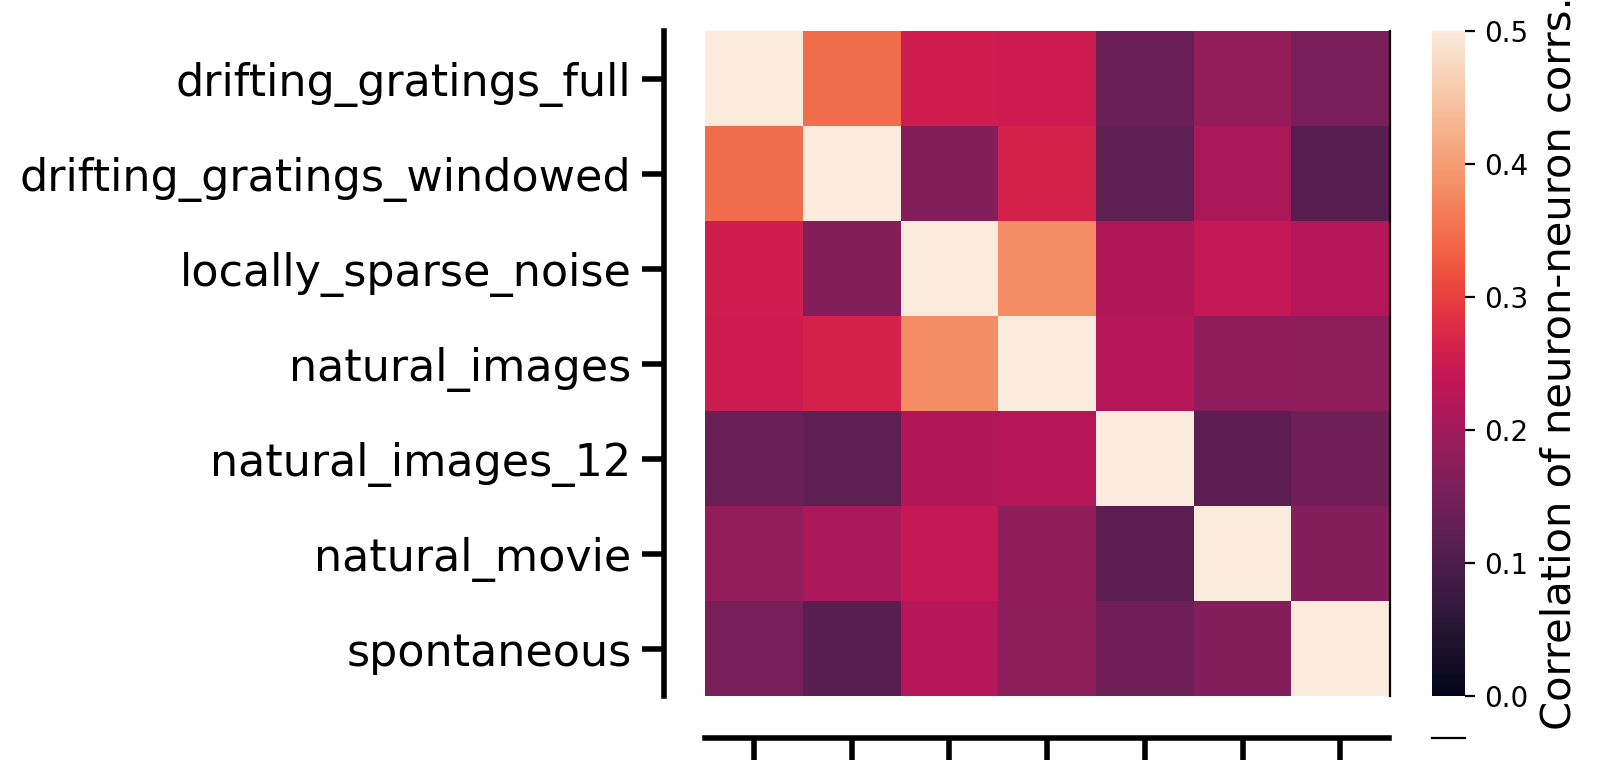

In [454]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

heatmap = sns.heatmap(stim_stim_corr_df, ax=ax, vmax=.5, vmin=0)
colorbar = heatmap.collections[0].colorbar
colorbar.set_label("Correlation of neuron-neuron corrs.", fontsize=15)

ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xticklabels([])
ax.set_xlabel("")
ax.set_ylabel("")
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Another way to compare the different stimulus conditions is to plot the distributions of the neuron-neuron correlations.

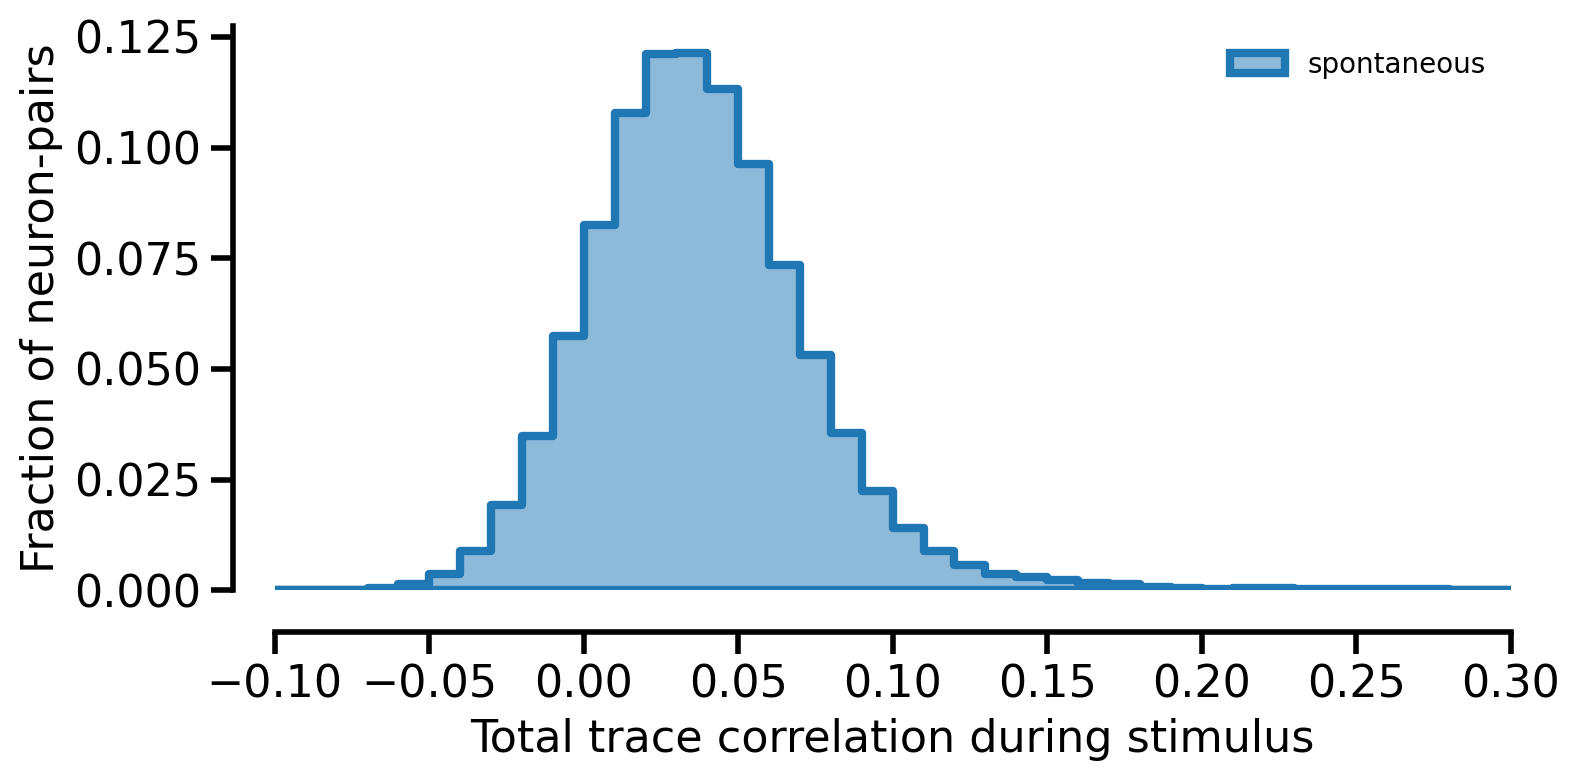

In [456]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

sns.histplot(data=corr_coreg_df, x=stim, label=stim, bins=np.linspace(-1, 1, 201), 
             element="step", lw=3, ax=ax, stat="probability", alpha=.5)

ax.legend(frameon=False)
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine
ax.set_xlim(-.1, .3)

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron-pairs", fontsize=16)
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Add the distributions for the other stimulus conditions into the same plot.

</div>

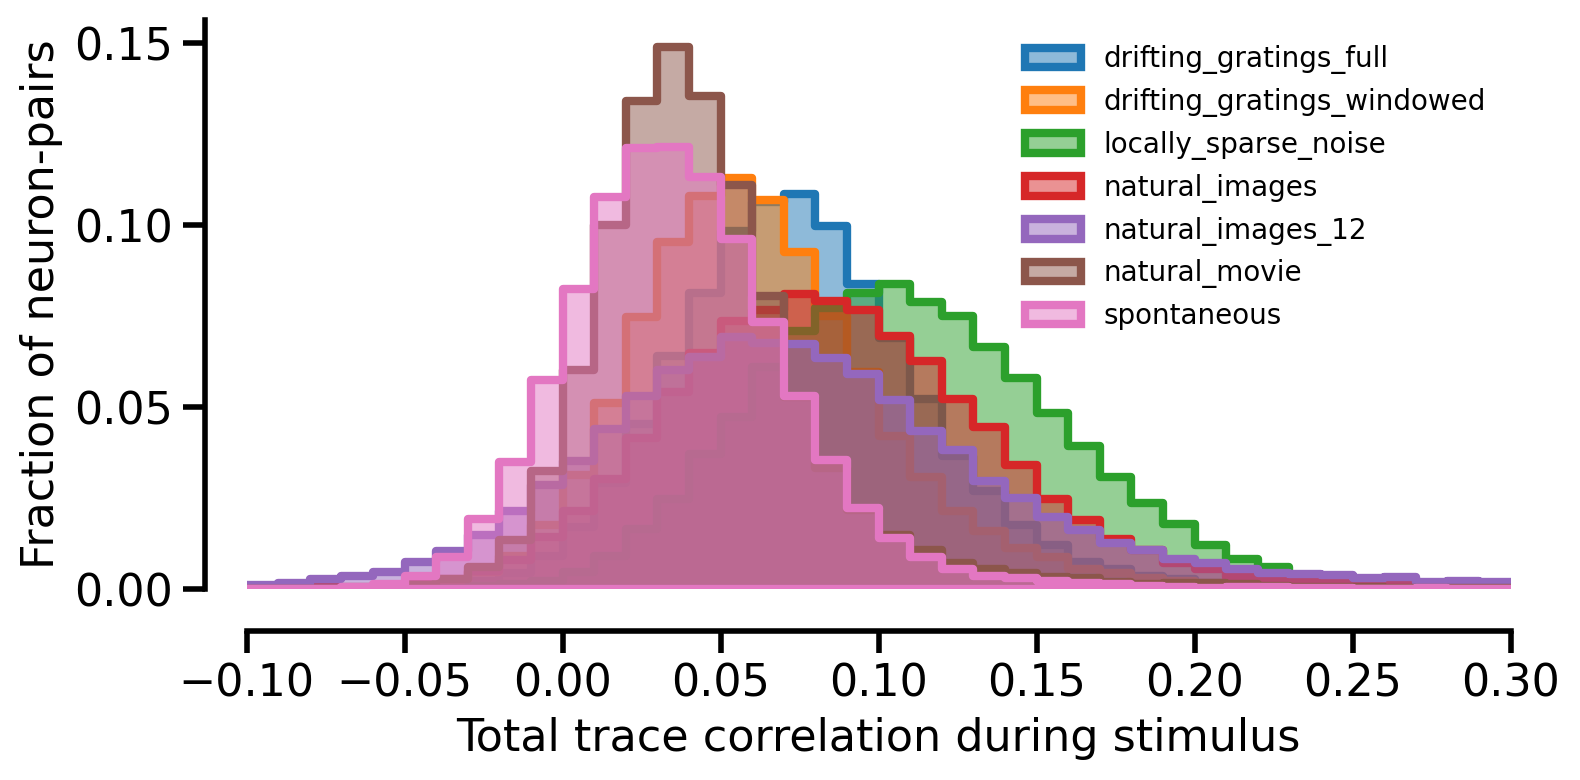

In [457]:
fig, ax = plt.subplots(figsize=(8, 4), dpi=200)

for stim in stimulus_conditions:
    sns.histplot(data=corr_coreg_df, x=stim, label=stim, bins=np.linspace(-1, 1, 201), 
                 element="step", lw=3, ax=ax, stat="probability", alpha=.5)

ax.legend(frameon=False)
ax.tick_params(axis='both', which='major', labelsize=16, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine
ax.set_xlim(-.1, .3)

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron-pairs", fontsize=16)
sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

With the activity correlation between neurons in hand, we want to answer one question: <b>Are neurons that are more correlated in their activity, more likely to be connected with each other?</b>

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

As before, we will limit this analysis to L3-IT neurons. We collect the connectivity information between these neurons as before.

In [479]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]

In [486]:
pre_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

In [487]:
analysis_syn_df = filter_synapse_table(syn_df, axon_proof_root_ids, dendrite_proof_root_ids).reset_index(drop=True)
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

We will limit our analysis to just those neurons for which we have proofreading data available

In [488]:
corr_coreg_proofread_df = corr_coreg_df.copy()
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["pre_pt_root_id"], pre_root_ids)]
corr_coreg_proofread_df = corr_coreg_proofread_df[np.isin(corr_coreg_proofread_df["post_pt_root_id"], post_root_ids)]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's compare the connectivity and the activity correlation data.

In [489]:
conn_corr_df = pd.merge(conn_df, corr_coreg_proofread_df, on=["pre_pt_root_id", "post_pt_root_id"])

In [490]:
corr_coreg_proofread_df.shape, conn_corr_df.shape

((13330, 9), (315, 10))

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

For a given stimulus, we compare the distributions of activity correlations between the connected pairs with the activity correlations of all pairs.

In [491]:
stim = stimulus_conditions[3]
stim

'natural_images'

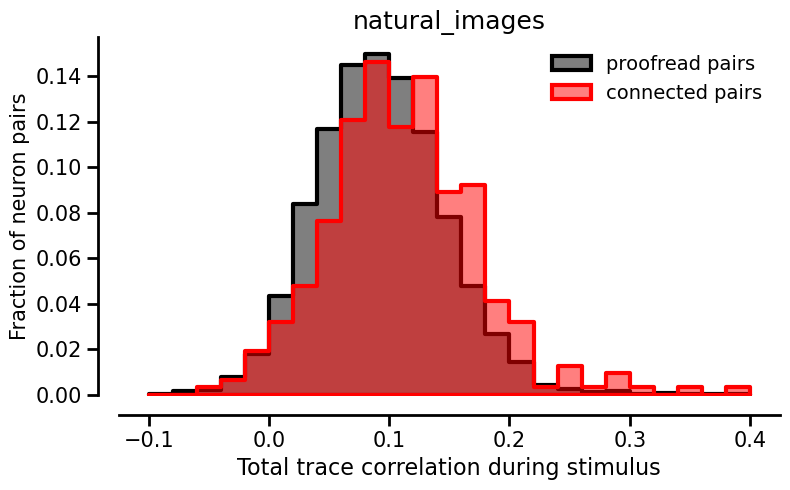

In [492]:
bins=np.linspace(-.1, .4, 26)

fig, ax = plt.subplots(figsize=(8, 5))

ax.set_title(stim, fontsize=18)

sns.histplot(corr_coreg_proofread_df, x=stim, stat="probability", bins=bins, element="step", label="proofread pairs", lw=3, fill=True, alpha=.5, color="k")
sns.histplot(conn_corr_df, x=stim, stat="probability", bins=bins, element="step", label="connected pairs", lw=3, fill=True, alpha=.5, color="r")

ax.legend(frameon=False, fontsize=14)

ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
sns.despine(offset=15, trim=False)
plt.tight_layout()

plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Just like for the distance analysis above (#1), we can express this result as a "connection probability" for a given correlation. That is, how likely is it that two neurons are connected given their activity correlation? 

Here, we will calculate the connection probability bins of activity correlations.

In [493]:
bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 6)) # Makes 5 bins

bin_centers = np.convolve(bins, [.5, .5], mode="valid") # Calulates the center of each bin

proofread_pair_counts = np.histogram(corr_coreg_proofread_df[stim], bins)[0]
connected_pair_counts = np.histogram(conn_corr_df[stim], bins)[0]

connection_probability = connected_pair_counts / (proofread_pair_counts + 1e-6)

/var/folders/q5/rdr80_4s4j7bnxdmr3q88qb80000gp/T/ipykernel_62431/2033719600.py:5: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  ax.legend(frameon=False, fontsize=14)


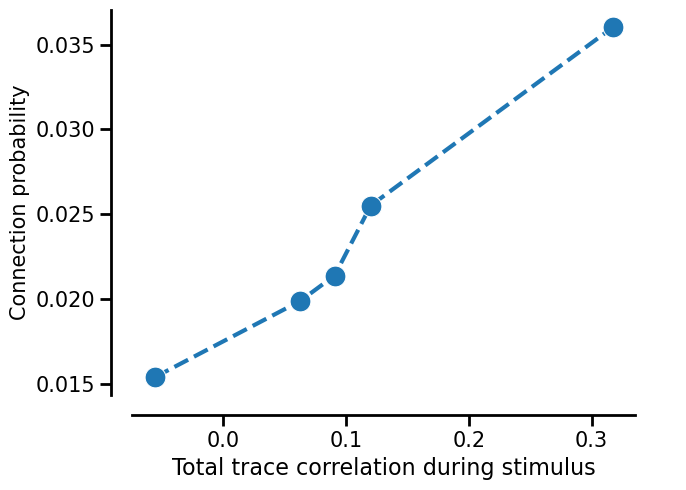

In [494]:
fig, ax = plt.subplots(figsize=(7, 5))

sns.lineplot(x=bin_centers, y=connection_probability, lw=3, ls="--", legend=False, ax=ax, marker="o", markersize=15)

ax.legend(frameon=False, fontsize=14)
ax.get_legend().set_bbox_to_anchor([1.1, 1])
ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="background: #DFF0D8; border-radius: 3px; padding: 10px;">

<p><b>Task:</b> Add the distributions for the other stimulus conditions into the same plot.

</div>

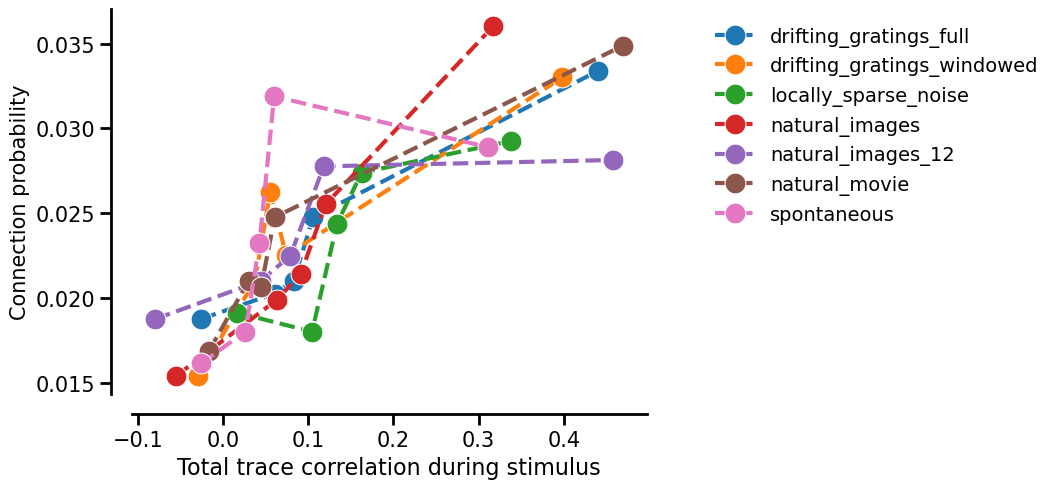

In [495]:
fig, ax = plt.subplots(figsize=(11, 5))

for stim in stimulus_conditions:
    bins = np.percentile(corr_coreg_proofread_df[stim], np.linspace(0, 100, 6))#[[0, 1, -2, -1]]

    bin_centers = np.convolve(bins, [.5, .5], mode="valid")#[[0, -1]]
    proofread_pair_counts = np.histogram(corr_coreg_proofread_df[stim], bins)[0]#[[0, -1]]
    connected_pair_counts = np.histogram(conn_corr_df[stim], bins)[0]#[[0, -1]]
    
    connection_probability = connected_pair_counts / (proofread_pair_counts + 1e-6)
    
    sns.lineplot(x=bin_centers, y=connection_probability, lw=3, ls="--", label=stim, legend=False, ax=ax, marker="o", markersize=15)

ax.legend(frameon=False, fontsize=14)
ax.get_legend().set_bbox_to_anchor([1.1, 1])
ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels

ax.spines['top'].set_visible(False)  # Hide the top spine
ax.spines['right'].set_visible(False)  # Hide the right spine
ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
ax.spines['left'].set_linewidth(2)  # Hide the right spine

ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
ax.set_ylabel("Connection probability", fontsize=15)

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

### Summary

We showed that for L3-IT cells

1. neurons that are closer to each other, are more likely to be connected.
2. neurons with more correlated activity traces, are more likely to be connected.

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

## A stronger NULL model: Can distance $\rightarrow$ connectivity account for structure-function correlation

So far we implicity used a _NULL model_ where all neuron pairs have the same likelihood to be connected. But we just showed that spatial separation alone increases the probability that two neurons are connected. Can this account for the correlation between activity correlation and connectivity?

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

Let's port the analysis from our distance based analysis

In [498]:
sub_cell_df = cell_df[cell_df["cell_type"] == "L3-IT"]
lateral_distance_df = calculate_lateral_distances(sub_cell_df)

pre_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], axon_proof_root_ids)]
post_root_ids = sub_cell_df["pt_root_id"][np.isin(sub_cell_df["pt_root_id"], dendrite_proof_root_ids)]

analysis_syn_df = filter_synapse_table(syn_df, pre_root_ids, post_root_ids).reset_index(drop=True)
conn_df = analysis_syn_df.groupby(["pre_pt_root_id", "post_pt_root_id"])["size"].sum().reset_index()

lateral_distance_proofread_df = lateral_distance_df.copy()
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["pre_pt_root_id"], pre_root_ids)]
lateral_distance_proofread_df = lateral_distance_proofread_df[np.isin(lateral_distance_proofread_df["post_pt_root_id"], post_root_ids)]

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Measurement:</b> We 

<div style="border-left: 3px solid #000; padding: 1px; padding-left: 10px; background: #F0FAFF; ">

<b>Distance-based null model to sample connectomes:</b> Using the probabilities we extraceted from the neuron-neuron distances, we will generate new connectomes to recreate the structure-function analysis.

In [288]:
bins = np.linspace(0, 500, 101)
proofread_pair_counts = np.histogram(lateral_distance_proofread_df["distance"], bins)[0]
connected_pair_counts = np.histogram(conn_dist_df["distance"], bins)[0]

connection_probability = connected_pair_counts / proofread_pair_counts

Let's build a dataframe that contains all our data

In [294]:
full_df = corr_coreg_proofread_df.copy()
full_df = pd.merge(full_df, lateral_distance_proofread_df, on=["pre_pt_root_id", "post_pt_root_id"])
full_df = pd.merge(full_df, conn_df, on=["pre_pt_root_id", "post_pt_root_id"], how="left").fillna(0)
full_df["connected"] = np.array(full_df["size"] > 0)

In [295]:
bins = np.linspace(0, 400, 11)
full_df["distance_bin"] = np.digitize(full_df["distance"], bins)
bin_to_conn_proba = full_df.groupby("distance_bin")["connected"].mean().to_dict()
full_df["conn_proba"] = full_df["distance_bin"].map(bin_to_conn_proba)

In [296]:
stim = stimulus_conditions[3]

In [297]:
connected_mean_corr = full_df[full_df["connected"]][stim].mean()
notconnected_mean_corr = full_df[~full_df["connected"]][stim].mean()

connected_mean_corr, notconnected_mean_corr

(np.float64(0.11141551284555128), np.float64(0.09270566243149558))

In [298]:
full_sampled_df = full_df.copy()

n_connected = np.sum(full_sampled_df["connected"])
sample_probas = np.array(full_sampled_df["conn_proba"])
sample_probas /= np.sum(sample_probas)

sampled_mean_corrs = []
for _ in tqdm.tqdm(range(10_000)):
    sampled_idx = np.random.choice(full_sampled_df.index, p=sample_probas, size=np.sum(full_sampled_df["connected"]))
    full_sampled_df["connected_sampled"] = False
    full_sampled_df.loc[sampled_idx, "connected_sampled"] = True

    sampled_mean_corrs.append(full_sampled_df[full_sampled_df["connected_sampled"]][stim].mean())

100%|████████████████████████████████| 10000/10000 [00:04<00:00, 2484.81it/s]


100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2663.83it/s]


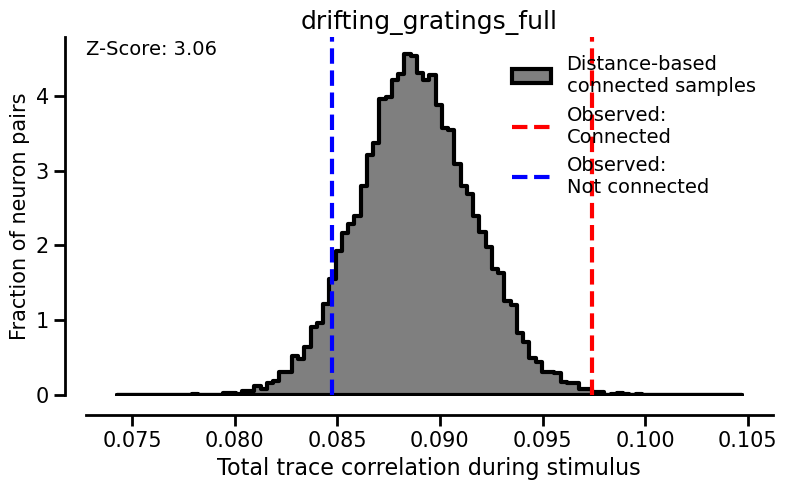

100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2664.63it/s]


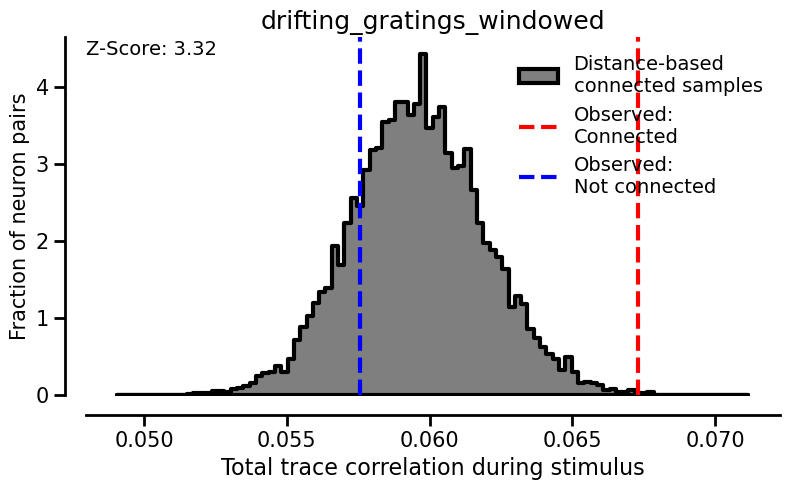

100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2691.58it/s]


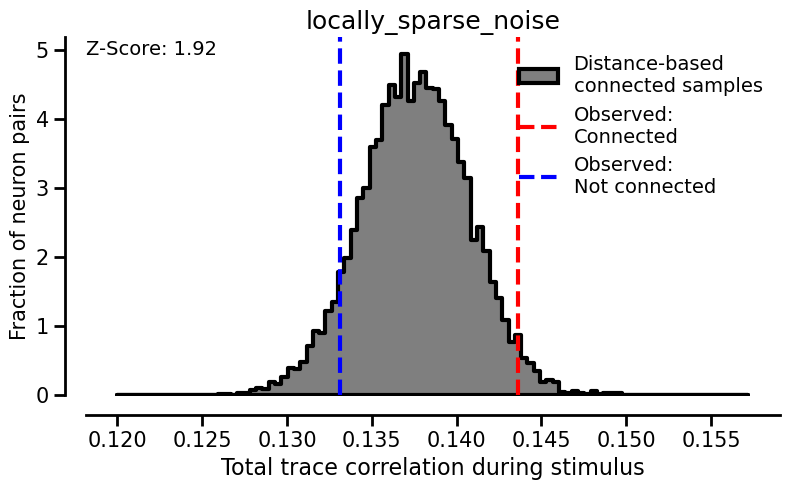

100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2662.81it/s]


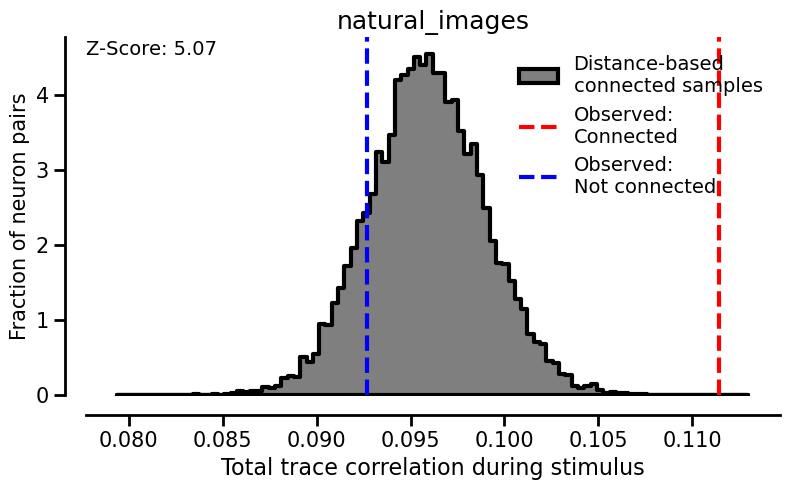

100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2634.66it/s]


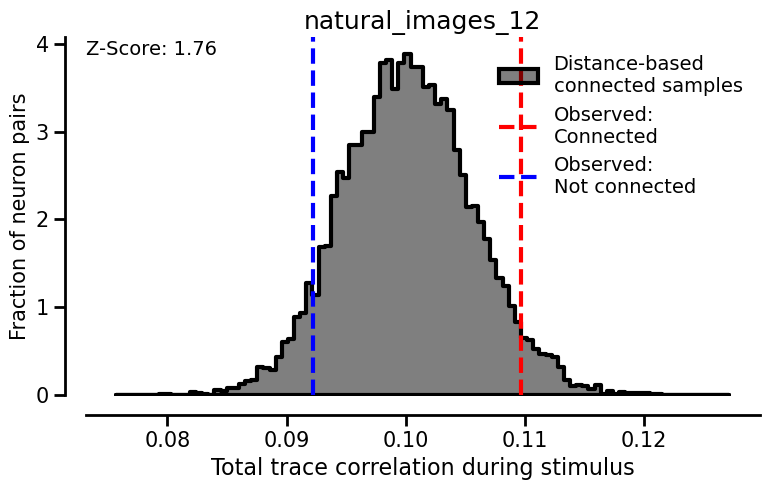

100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2670.25it/s]


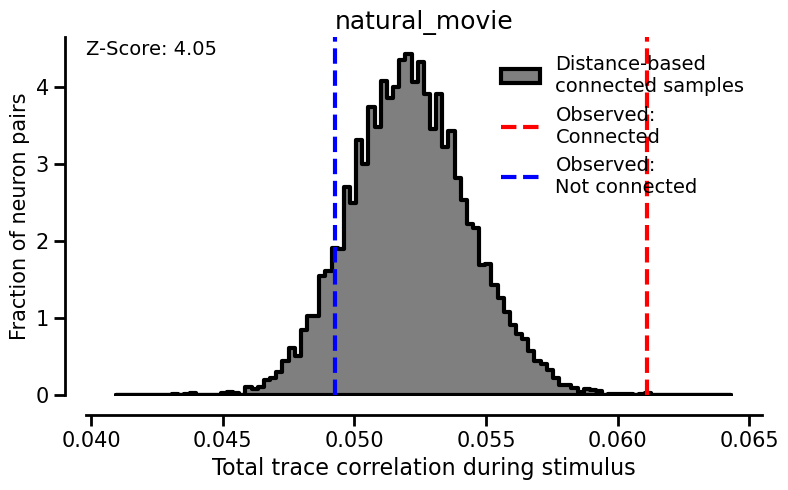

100%|████████████████████████████████| 10000/10000 [00:03<00:00, 2641.71it/s]


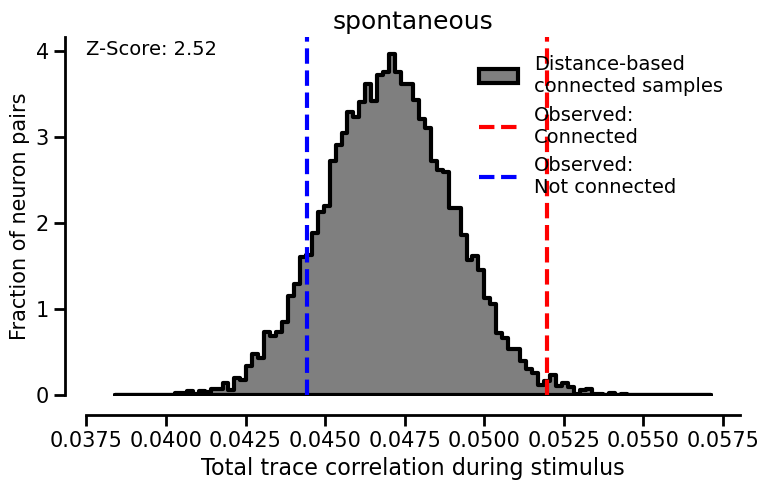

In [299]:
for stim in stimulus_conditions:

    connected_mean_corr = full_df[full_df["connected"]][stim].mean()
    notconnected_mean_corr = full_df[~full_df["connected"]][stim].mean()
    
    connected_mean_corr, notconnected_mean_corr

    full_sampled_df = full_df.copy()
    
    n_connected = np.sum(full_sampled_df["connected"])
    sample_probas = np.array(full_sampled_df["conn_proba"])
    sample_probas /= np.sum(sample_probas)
    
    sampled_mean_corrs = []
    for _ in tqdm.tqdm(range(10_000)):
        sampled_idx = np.random.choice(full_sampled_df.index, p=sample_probas, size=np.sum(full_sampled_df["connected"]))
        full_sampled_df["connected_sampled"] = False
        full_sampled_df.loc[sampled_idx, "connected_sampled"] = True
    
        sampled_mean_corrs.append(full_sampled_df[full_sampled_df["connected_sampled"]][stim].mean())
    
    zscore = (connected_mean_corr - np.mean(sampled_mean_corrs)) / np.std(sampled_mean_corrs)
    
    bins = np.linspace(np.min(sampled_mean_corrs) * .95, np.max(sampled_mean_corrs) * 1.05, 101)
                       
    fig, ax = plt.subplots(figsize=(8, 5))
    
    ax.set_title(stim, fontsize=18)
    
    sns.histplot(x=sampled_mean_corrs, stat="percent", bins=bins, element="step", label="Distance-based\nconnected samples", 
                 lw=3, fill=True, alpha=.5, color="k")
    
    ax.axvline(x=np.mean(full_df[stim][full_df["connected"]]), color='r', linestyle='--', label='Observed:\nConnected', lw=3)
    ax.axvline(x=np.mean(full_df[stim][~full_df["connected"]]), color='b', linestyle='--', label='Observed:\nNot connected', lw=3)
    
    
    ax.legend(frameon=False, fontsize=14)
    
    ax.text(ax.get_xlim()[0], ax.get_ylim()[1] * .95, f"Z-Score: {zscore:.2f}", fontsize=14)
    
    ax.tick_params(axis='both', which='major', labelsize=15, width=2, length=8)  # Set larger tick labels
    ax.tick_params(axis='both', which='minor', labelsize=14, width=1, length=4)  # Set larger tick labels
    
    ax.spines['top'].set_visible(False)  # Hide the top spine
    ax.spines['right'].set_visible(False)  # Hide the right spine
    ax.spines['bottom'].set_linewidth(2)  # Hide the top spine
    ax.spines['left'].set_linewidth(2)  # Hide the right spine
    
    ax.set_xlabel("Total trace correlation during stimulus", fontsize=16)
    ax.set_ylabel("Fraction of neuron pairs", fontsize=15)
    sns.despine(offset=15, trim=False)
    plt.tight_layout()
    
    plt.show()

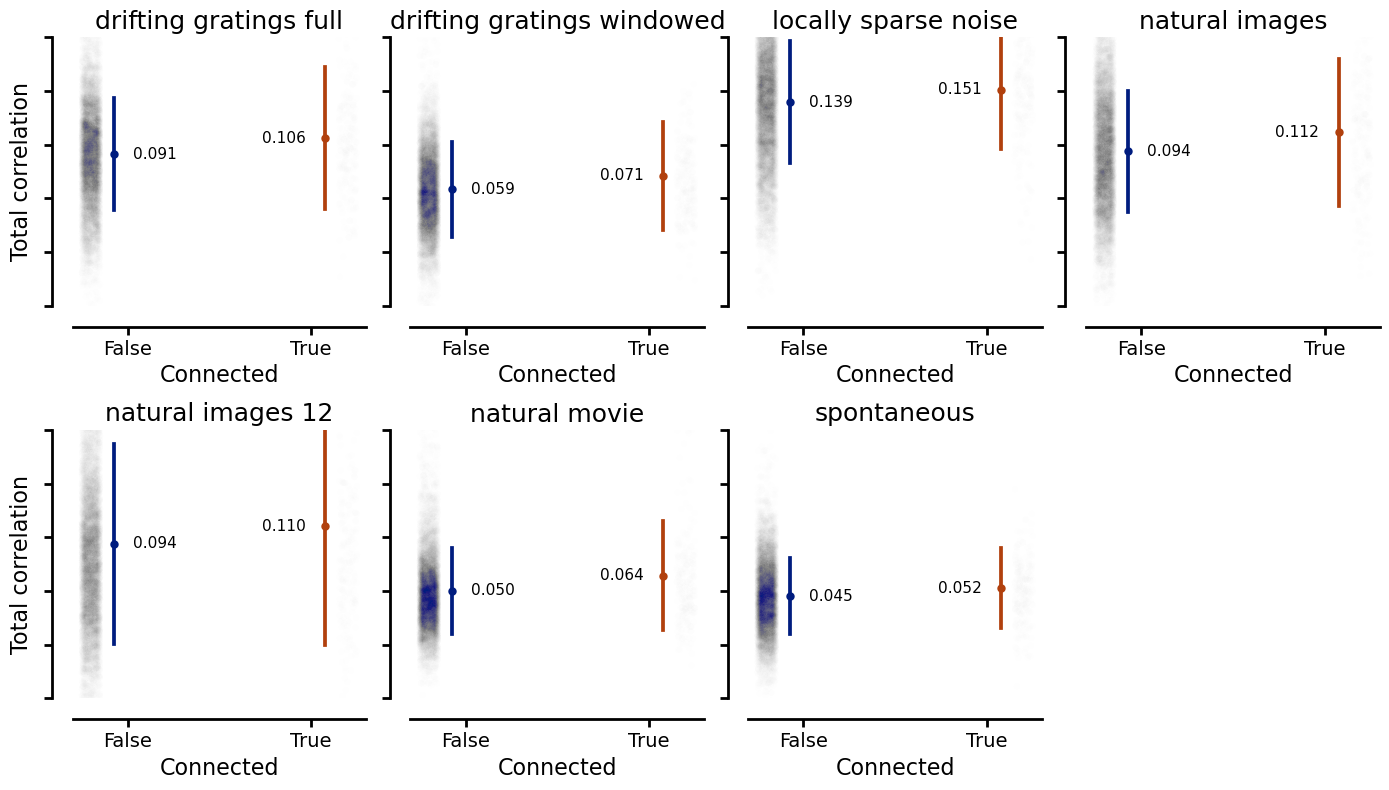

In [212]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14, 8), sharey=True)
axes = axes.flatten()  # flatten to 1D list for easy indexing

for stim, ax in zip(stim_list, axes):
    means = corr_conn_full_df.groupby("connected")[stim].mean()
    ax.set_title(stim.replace("_", " "), fontsize=18)
    ax.tick_params(axis='both', which='major', labelsize=14, width=2, length=6)
    ax.tick_params(axis='both', which='minor', labelsize=12, width=1, length=4)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['bottom'].set_linewidth(2)
    ax.spines['left'].set_linewidth(2)

    sns.stripplot(
        data=corr_conn_full_df, y=stim, x="connected", hue="connected",
        alpha=0.005, palette="dark", dodge=0.15, legend=False, ax=ax
    )

    sns.pointplot(
        data=corr_conn_full_df, x="connected", y=stim, hue="connected",
        dodge=0.15, palette="dark", errorbar="sd",
        markers="o", markersize=4, linestyle="none", ax=ax, legend=False
    )

    # Annotate means at custom x positions
    ax.text(0.15, means.loc[False], f"{means.loc[False]:.3f}", ha="center", va="center", fontsize=11, color="black")
    ax.text(0.85, means.loc[True], f"{means.loc[True]:.3f}", ha="center", va="center", fontsize=11, color="black")

    ax.set_xticks([0, 1])
    ax.set_xticklabels(["False", "True"], fontsize=14)

    if ax is axes[0] or ax is axes[4]:  # left-most in each row
        ax.set_ylabel("Total correlation", fontsize=16)
    else:
        ax.set_ylabel("")
        ax.set_yticklabels([])

    ax.set_xlabel("Connected", fontsize=16)
    ax.set_ylim(-.05, .2)
    ax.set_xlim(-0.3, 1.3)

# Hide any unused subplot (e.g., the 8th panel)
if len(stim_list) < len(axes):
    for ax in axes[len(stim_list):]:
        ax.axis('off')

sns.despine(offset=15, trim=False)
plt.tight_layout()
plt.show()
